# Probabilistic Modeling Different Keras Backends (JAX)

Currently (November 2024) we have to create a wrapper object making the distribution. 

In [3]:
import numpy as np
np.random.seed(42)
x_train = np.random.uniform(-10, 10, (1000, 1)).astype(np.float32)
y_train = (2 * x_train + np.random.normal(0, np.abs(x_train) + 1, (1000, 1))).astype(np.float32)

In [4]:
import os
import jax 
print(F'jax.__version__    : {jax.__version__}')
os.environ["KERAS_BACKEND"] = "jax" # set backend before importing keras 

import numpyro
print(F'numpyro.__version__: {numpyro.__version__}')

import keras
print(F'keras.__version__  : {keras.__version__}')
import jax.numpy as jnp
from jax import random
from numpyro import distributions as dist
import time

jax.__version__    : 0.4.26
numpyro.__version__: 0.15.3
keras.__version__  : 3.6.0


Currently there is no `DistributionLayer` in Keras 3.0, as there is in tf_keras (see [pm_tfkeras.ipynb](https://github.com/tensorchiefs/dl_keras3/blob/main/notebooks/probabilistic_modelling/pm_tfkeras.ipynb)). Therefore we create a wrapper object that takes the output of the NN and returns a numpyro distribution object.  

In [5]:
@staticmethod
def output_to_gaussian_distribution(out):
    mean = out[:, :1]       # first column is mean
    log_var = out[:, 1:]    # last column is log variance
    return dist.Normal(mean, jnp.exp(log_var))

In [6]:
# Define the model
inputs = keras.Input(shape=(1,), dtype=np.float32)
hidden = keras.layers.Dense(10, activation="relu")(inputs)
output = keras.layers.Dense(2)(hidden)


# Define the Keras model
model = keras.Model(inputs=inputs, outputs=output)

# Custom Negative Log-Likelihood Loss
def negative_log_likelihood(y_true, output):
    dist = output_to_gaussian_distribution(output)
    return -jnp.mean(dist.log_prob(y_true))  # Negative log-likelihood

# Compile the model
model.compile(optimizer="adam", loss=negative_log_likelihood)

print(F'Prediction on untrained model (5 Datapoints) {model.predict(x_train[1:5])}')

# Train the model and measure timing
start_time = time.time()
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
jax_training_time = time.time() - start_time

print(f"JAX Training Time: {jax_training_time:.2f} seconds")

# Predict the distribution
x_test = jnp.linspace(-10, 10, 100).reshape(-1, 1)
dist = output_to_gaussian_distribution(model(x_test))

# Use the distribution
samples = dist.sample(random.PRNGKey(0), (5,))  # Draw 5 samples
cdf_values = dist.cdf(0.0)  # CDF at y = 0
print("JAX Samples:", samples.shape)
print("JAX CDF Values:", cdf_values.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Prediction on untrained model (5 Datapoints) [[ 3.1215818  2.9337327]
 [ 1.6067563  1.5100657]
 [ 0.6832943  0.6421754]
 [-1.0686277  1.4356835]]
JAX Training Time: 0.83 seconds
JAX Samples: (5, 100, 1)
JAX CDF Values: (100, 1)


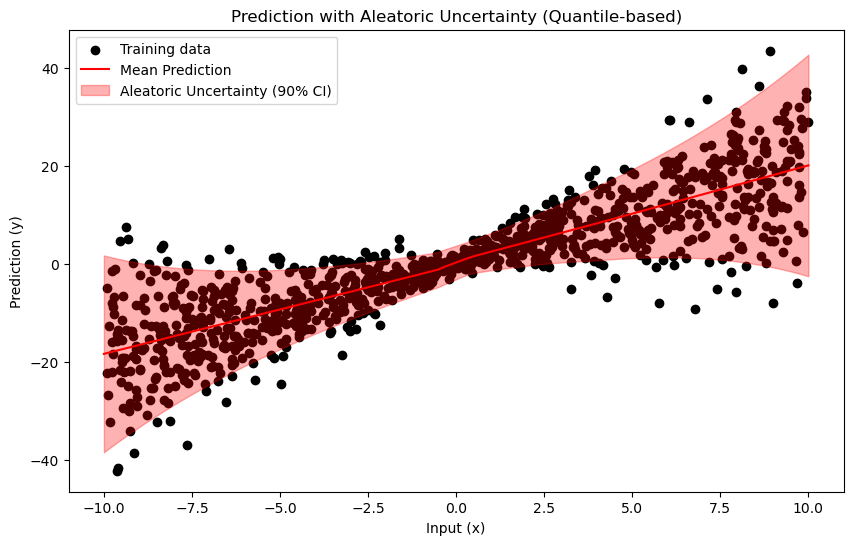

In [21]:
# Berechne Quantile direkt aus der Verteilung
quantile_5 = dist.icdf(0.05)  # 5%-Quantil
quantile_95 = dist.icdf(0.95)  # 95%-Quantil

# Visualisierung
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color="black", label="Training data")
plt.plot(x_test, dist.mean.squeeze(), color="red", label="Mean Prediction")
plt.fill_between(
    x_test.ravel(),
    quantile_5.squeeze(),  # 5%-Quantil
    quantile_95.squeeze(),  # 95%-Quantil
    color="red",
    alpha=0.3,
    label="Aleatoric Uncertainty (90% CI)"
)
plt.legend()
plt.xlabel("Input (x)")
plt.ylabel("Prediction (y)")
plt.title("Prediction with Aleatoric Uncertainty (Quantile-based)")
plt.show()